# Differential regulation of APA under diauxic stress

**Purpose**: To identify polyA sites differentially regulated when yeast are under diauxic stress.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from statsmodels.stats.multitest import multipletests

In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
DATADIR   = os.path.join(PROJECT, 'saccharomyces_cerevisiae', 'analysis', 'dapa')
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'differential_apa')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
boxplot_format = {
    'color'        : 'lightgray',
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

In [7]:
light_cmap = {
    -1: '#548fb3',
    0 : '#d6e4ec', 
    1 : '#f6ddce', 
    2 : '#c56d5f'
}

dark_cmap = {
    -1: '#548fb3',
    0 : '#808080', 
    1 : '#f6ddce',
    2 : '#c56d5f'
}

## ANALYSIS

In [8]:
dapa_data = pd.read_csv(os.path.join(RESOURCES, 'dapa_clusters.polya_comprehensive.txt'), sep = "\t").drop(columns = ['max_cleavage'])
dapa_data = dapa_data.loc[~dapa_data.isin([np.nan, np.inf, -np.inf]).any(1)]
print(dapa_data.shape)


(9089, 26)


#### Annotate sites with supporting reads, relative usage score, and change in usage

In [9]:
dapa_data['label'] = dapa_data.apply(lambda row : f'{row.name:06d}:{row.chrom}:{row.start}:{row.strand}', axis = 1)
dapa_data['ctr_cleavage'] = 250


In [10]:
dapa_data['classificationCLIP'] = np.clip(dapa_data['classification'], a_min = 1e-6, a_max = 1 - 1e-6)
dapa_data['classificationLO'] = np.log2(dapa_data['classificationCLIP'] / (1 - dapa_data['classificationCLIP']))


In [11]:
cluster_reads_dict = defaultdict(dict)

for i,row in dapa_data.iterrows():
    cluster_reads_dict[(row['gene'],row['tissue'])][row['relative_position']] = row['reads_cluster_interest']


In [12]:
dapa_data['relusage'] = dapa_data.apply(lambda row : row['reads_cluster_interest'] / np.sum(list(cluster_reads_dict[(row['gene'],row['tissue'])].values())), axis = 1)
print(dapa_data['relusage'].describe())


notebook_setup.py:1: RuntimeWarning: invalid value encountered in double_scalars
  import os, re, sys, copy, glob, math, tqdm, scipy, random, itertools, logomaker


count    8836.000000
mean        0.504301
std         0.387959
min         0.000014
25%         0.083591
50%         0.510456
75%         0.922078
max         1.000000
Name: relusage, dtype: float64


In [13]:
gene_counts = dapa_data['gene'].value_counts()
unpaired_genes = sorted(gene_counts[gene_counts != 2].index.tolist())
print(len(unpaired_genes), unpaired_genes[:5])

dapa_data = dapa_data.loc[~dapa_data['gene'].isin(unpaired_genes)].copy()
print(dapa_data.shape)


329 ['YAL024C', 'YAL030W', 'YAL067C', 'YAR031W', 'YAR068W']
(8760, 31)


In [14]:
## confirm that the relative usage scores sum to 1 for all sites in a gene
print(dapa_data.groupby(['gene','tissue'])['relusage'].agg(sum).describe())


count    4.380000e+03
mean     1.000000e+00
std      1.751604e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: relusage, dtype: float64


#### Assess site change in usage and calculate Benjamini-Hochberg corrected p-values

In [15]:
dapa_data['deltaUsage']  = dapa_data['usage_interest'] - dapa_data['usage_others']
dapa_data['l2fcUsage']   = np.log2(dapa_data['usage_interest'] / dapa_data['usage_others'])
dapa_data['l2or']        = np.log2(dapa_data['odds_ratio'])
dapa_data['pval_minlog'] = -1 * np.log10(dapa_data['pval'])
dapa_data['qval']        = multipletests(dapa_data['pval'], alpha = 0.05, method = 'fdr_bh')[1]
dapa_data['qval_minlog'] = -1 * np.log10(dapa_data['qval'])


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Compile site positions and strength scores

In [16]:
site_data = defaultdict(dict)

for i,row in dapa_data.iterrows():
    site_data[row['gene']][row['relative_position']] = {
        'position' : row['repr_site'],
        'strength' : row['pred_logit'],
    }


#### Identify the site relative position (i.e. proximal or distal) and calculate the distance and difference in strength

In [17]:
dapa_data.loc[dapa_data['relative_position'] == 'proximal', 'pair_distance'] = dapa_data.loc[dapa_data['relative_position'] == 'proximal'].apply(lambda row : np.abs(site_data[row['gene']].get('distal', {}).get('position', np.nan) - row['repr_site']), axis = 1)
dapa_data.loc[dapa_data['relative_position'] == 'distal',   'pair_distance'] = dapa_data.loc[dapa_data['relative_position'] == 'distal'].apply(lambda row : np.abs(site_data[row['gene']].get('proximal', {}).get('position', np.nan) - row['repr_site']), axis = 1)

dapa_data['pair_distance_log10'] = np.log10(dapa_data['pair_distance'])
print(dapa_data['pair_distance_log10'].describe())


count    8760.000000
mean        1.987361
std         0.270244
min         1.698970
25%         1.792392
50%         1.908485
75%         2.096910
max         3.886773
Name: pair_distance_log10, dtype: float64


In [18]:
dapa_data.loc[dapa_data['relative_position'] == 'proximal', 'strength_difference'] = dapa_data.loc[dapa_data['relative_position'] == 'proximal'].apply(lambda row : row['pred_logit'] - site_data[row['gene']].get('distal', {}).get('strength', np.nan), axis = 1)
dapa_data.loc[dapa_data['relative_position'] == 'distal',   'strength_difference'] = dapa_data.loc[dapa_data['relative_position'] == 'distal'].apply(lambda row : row['pred_logit'] - site_data[row['gene']].get('proximal', {}).get('strength', np.nan), axis = 1)
print(dapa_data['strength_difference'].describe())


count    8760.000000
mean        0.000000
std         1.909134
min        -7.383472
25%        -1.191047
50%         0.000000
75%         1.191047
max         7.383472
Name: strength_difference, dtype: float64


In [19]:
dapa_data.loc[dapa_data['relative_position'] == 'proximal', 'strength_paired'] = dapa_data.loc[dapa_data['relative_position'] == 'proximal']['gene'].apply(lambda x : site_data[x].get('distal', {}).get('strength', np.nan))
dapa_data.loc[dapa_data['relative_position'] == 'distal',   'strength_paired'] = dapa_data.loc[dapa_data['relative_position'] == 'distal'  ]['gene'].apply(lambda x : site_data[x].get('proximal', {}).get('strength', np.nan))
print(dapa_data['strength_paired'].describe())


count    8760.000000
mean       -2.537367
std         1.231816
min        -6.251997
25%        -3.363144
50%        -2.649392
75%        -1.873953
max         2.478335
Name: strength_paired, dtype: float64


In [20]:
print("Input data shape :", dapa_data.shape)
print("\nNumber of sites  :", dapa_data[['gene','relative_position']].drop_duplicates().shape[0])
print("Number of tissues:", dapa_data['tissue'].nunique())
print("Number of genes  :", dapa_data['gene'].nunique())


Input data shape : (8760, 41)

Number of sites  : 8760
Number of tissues: 1
Number of genes  : 4380


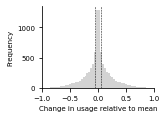

In [21]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

ax.hist(dapa_data['deltaUsage'], bins = 50, color = 'lightgray')

ax.axvline(-0.05, color = 'black', linestyle = 'dashed', linewidth = 0.5)
ax.axvline(+0.05, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Change in usage relative to mean")
ax.set_xlim(-1,1)

ax.set_ylabel("Frequency")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


#### Selecting significantly differentially-used sites

In [22]:
qval_cutoff = 0.05

cond1 = (dapa_data['relative_position'] == 'proximal')
cond2 = (dapa_data['usage_interest'] >= 0.2)
cond3 = (dapa_data['qval_minlog'] >= -1 * np.log10(qval_cutoff))

sig_prox = dapa_data.loc[cond1 & cond2 & cond3].copy()

print("Proximal sites         :", cond1.sum())
print("Baseline usage >= 20%  :", cond2.sum())
print("Adjusted p-value < 0.05:", cond3.sum())
print("COMBINED               :", (cond1 & cond2 & cond3).sum())


Proximal sites         : 4380
Baseline usage >= 20%  : 5692
Adjusted p-value < 0.05: 7304
COMBINED               : 2976


In [23]:
bins = [-1,-0.05,0.05,0.25,1]
labs = np.arange(-1,3,1)

sig_prox['sigbin'] = pd.cut(sig_prox['deltaUsage'], bins = bins)
print(sig_prox['sigbin'].value_counts(sort = False))

sig_prox['sigbinL'] = pd.cut(sig_prox['deltaUsage'], bins = bins, labels = labs)
print(sig_prox['sigbinL'].value_counts(sort = False))

sigbinR_type = pd.api.types.CategoricalDtype(categories = list(reversed(sorted(sig_prox['sigbin'].unique()))), ordered = True)
sig_prox['sigbinR'] = sig_prox['sigbin'].copy().astype(sigbinR_type)
print(sig_prox['sigbinR'].value_counts(sort = False))


(-1.0, -0.05]     252
(-0.05, 0.05]     612
(0.05, 0.25]     1157
(0.25, 1.0]       955
Name: sigbin, dtype: int64
-1     252
 0     612
 1    1157
 2     955
Name: sigbinL, dtype: int64
(0.25, 1.0]       955
(0.05, 0.25]     1157
(-0.05, 0.05]     612
(-1.0, -0.05]     252
Name: sigbinR, dtype: int64


In [24]:
sig_prox['sigbinR'].value_counts(sort = False, normalize = True)

(0.25, 1.0]      0.320901
(0.05, 0.25]     0.388777
(-0.05, 0.05]    0.205645
(-1.0, -0.05]    0.084677
Name: sigbinR, dtype: float64

#### Find matched distal sites for downstream comparison

In [25]:
paired_dist = dapa_data.loc[dapa_data['gene'].isin(sig_prox['gene']) & (dapa_data['relative_position'] == 'distal')].copy()
print(len(paired_dist))

sigbin_dict = dict(zip(sig_prox['gene'], sig_prox['sigbinL']))
paired_dist['sigbinL'] = paired_dist['gene'].apply(lambda x : sigbin_dict[x])
print(paired_dist['sigbinL'].value_counts())


2976
 1    1157
 2     955
 0     612
-1     252
Name: sigbinL, dtype: int64


In [26]:
paired_dist = dapa_data.loc[dapa_data['gene'].isin(sig_prox['gene']) & (dapa_data['relative_position'] == 'distal')].copy()
print(len(paired_dist))

sigbin_dict = dict(zip(sig_prox['gene'], sig_prox['sigbinL']))
paired_dist['sigbinL'] = paired_dist['gene'].apply(lambda x : sigbin_dict[x])
print(paired_dist['sigbinL'].value_counts())


2976
 1    1157
 2     955
 0     612
-1     252
Name: sigbinL, dtype: int64


#### Record processed data

In [27]:
with open(os.path.join(OUTDIR, 'dapa_data.pickle'), mode = 'wb') as handle:
    pickle.dump(dapa_data, handle)

with open(os.path.join(OUTDIR, 'dapa_data.significant_proximal_sites.pickle'), mode = 'wb') as handle:
    pickle.dump(sig_prox, handle)
    
with open(os.path.join(OUTDIR, 'dapa_data.paired_distal_sites.pickle'), mode = 'wb') as handle:
    pickle.dump(paired_dist, handle)
    

In [28]:
prox_dict = dict(zip(sig_prox['label'], sig_prox['sigbinL']))
dist_dict = dict(zip(paired_dist['label'], paired_dist['sigbinL']))

with open(os.path.join(OUTDIR, 'dapa_data.proximal_delta_usage_groups.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_dict, handle)

with open(os.path.join(OUTDIR, 'dapa_data.distal_delta_usage_groups.pickle'), mode = 'wb') as handle:
    pickle.dump(dist_dict, handle)

print("Proximal sites recorded:", len(list(prox_dict.keys())))
print("Distal sites recorded  :", len(list(dist_dict.keys())))


Proximal sites recorded: 2976
Distal sites recorded  : 2976


In [29]:
sig_prox.sort_values('gene').to_csv(os.path.join(OUTDIR, 'proximal_sites.txt'), sep = "\t", index = False)
paired_dist.sort_values('gene').to_csv(os.path.join(OUTDIR, 'distal_sites.txt'), sep = "\t", index = False)


## Examples of differentially-used sites

In [30]:
example_cols = ['chrom','start','end','strand','cluster','gene','feature','reads_cluster_interest','reads_outside_interest','reads_cluster_others','reads_outside_others','usage_interest','usage_others','deltaUsage','odds_ratio','pval','pval_minlog','pair_distance','pred_logit','strength_difference','sigbin']


#### Strong proximal shift

In [31]:
sig_prox.loc[sig_prox['gene'] == 'YGR060W'].iloc[0][example_cols]

chrom                                      VII
start                                   611671
end                                     611690
strand                                       +
cluster                   fwd:wt_cluster:35793
gene                                   YGR060W
feature                                   utr3
reads_cluster_interest                   989.5
reads_outside_interest                     530
reads_cluster_others                       411
reads_outside_others                      2820
usage_interest                        0.651201
usage_others                          0.127205
deltaUsage                            0.523996
odds_ratio                             12.8099
pval                              3.12302e-298
pval_minlog                            297.505
pair_distance                              132
pred_logit                            -1.21437
strength_difference                    1.19337
sigbin                             (0.25, 1.0]
Name: 3428, d

In [32]:
sig_prox.loc[sig_prox['gene'] == 'YCL057W'].iloc[0][example_cols]

chrom                                     III
start                                   26972
end                                     27000
strand                                      +
cluster                   fwd:wt_cluster:8318
gene                                  YCL057W
feature                                  utr3
reads_cluster_interest                   8964
reads_outside_interest                    749
reads_cluster_others                     5007
reads_outside_others                     3976
usage_interest                       0.922887
usage_others                         0.557386
deltaUsage                           0.365501
odds_ratio                            9.50361
pval                                        0
pval_minlog                               inf
pair_distance                              56
pred_logit                           -3.19507
strength_difference                  -1.89161
sigbin                            (0.25, 1.0]
Name: 864, dtype: object

#### Moderate proximal shift

In [33]:
sig_prox.loc[sig_prox['gene'] == 'YPL045W'].iloc[0][example_cols]

chrom                                      XVI
start                                   469702
end                                     469738
strand                                       +
cluster                   fwd:wt_cluster:96783
gene                                   YPL045W
feature                                   utr3
reads_cluster_interest                     423
reads_outside_interest                     447
reads_cluster_others                       396
reads_outside_others                       960
usage_interest                        0.486207
usage_others                          0.292035
deltaUsage                            0.194171
odds_ratio                             2.29408
pval                                2.8543e-20
pval_minlog                            19.5445
pair_distance                              176
pred_logit                            -3.85901
strength_difference                  -0.081998
sigbin                            (0.05, 0.25]
Name: 8708, d

#### Distal shift

In [34]:
sig_prox.loc[sig_prox['gene'] == 'YOR091W'].iloc[0][example_cols]

chrom                                       XV
start                                   494520
end                                     494544
strand                                       +
cluster                   fwd:wt_cluster:86804
gene                                   YOR091W
feature                                   utr3
reads_cluster_interest                    2591
reads_outside_interest                  1534.5
reads_cluster_others                      6403
reads_outside_others                    1292.5
usage_interest                        0.628045
usage_others                          0.832045
deltaUsage                              -0.204
odds_ratio                            0.340838
pval                              2.32991e-135
pval_minlog                            134.633
pair_distance                              434
pred_logit                            -2.90609
strength_difference                   -1.72153
sigbin                           (-1.0, -0.05]
Name: 8162, d

In [35]:
sig_prox.loc[sig_prox['gene'] == 'YPR196W'].iloc[0][example_cols]

chrom                                      XVI
start                                   932946
end                                     932971
strand                                       +
cluster                   fwd:wt_cluster:96818
gene                                   YPR196W
feature                                   utr3
reads_cluster_interest                   566.5
reads_outside_interest                  1474.5
reads_cluster_others                       432
reads_outside_others                       269
usage_interest                         0.27756
usage_others                          0.616262
deltaUsage                           -0.338702
odds_ratio                            0.239234
pval                               7.50596e-58
pval_minlog                            57.1246
pair_distance                              239
pred_logit                            -1.73744
strength_difference                   0.501922
sigbin                           (-1.0, -0.05]
Name: 9414, d

## Characterizing differentially-used proximal sites

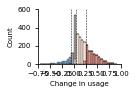

In [36]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1))

ax.axvline(x = -0.05, color = 'black', linewidth = 0.5, linestyle = 'dashed')
ax.axvline(x = +0.05, color = 'black', linewidth = 0.5, linestyle = 'dashed')
ax.axvline(x = +0.25, color = 'black', linewidth = 0.5, linestyle = 'dashed')

sns.histplot(data = sig_prox, x = 'deltaUsage', binwidth = 0.05, 
             hue = 'sigbinL', palette = dark_cmap, multiple = 'stack',
             edgecolor = 'black', linewidth = 0.25, ax = ax)

ax.set_xlabel("Change in usage")

ax.set_xlim(-0.75,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))

ax.set_ylim(0,600)
ax.yaxis.set_major_locator(MultipleLocator(200))

ax.get_legend().remove()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'delta_usage.distribution.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


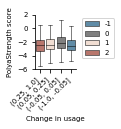


Corresponding statistics-
	Wilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:	  4.045 5.23E-05
	Wilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:	  6.952 3.59E-12

Summary data-
                count      mean       std       min       25%       50%  \
sigbinR                                                                   
(0.25, 1.0]     955.0 -2.488023  1.169277 -5.772046 -3.332057 -2.482141   
(0.05, 0.25]   1157.0 -2.264225  1.204769 -5.974615 -3.066422 -2.388459   
(-0.05, 0.05]   612.0 -1.986700  1.320411 -5.432456 -2.902337 -2.150423   
(-1.0, -0.05]   252.0 -2.378856  1.117302 -5.720830 -3.168545 -2.561627   

                    75%       max  
sigbinR                            
(0.25, 1.0]   -1.786367  1.534299  
(0.05, 0.25]  -1.618187  1.974897  
(-0.05, 0.05] -1.235184  1.742638  
(-1.0, -0.05] -1.755585  1.627056  


In [37]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1))

sns.boxplot(data = sig_prox, 
            x = 'sigbinR', y = 'pred_logit', 
            hue = 'sigbinL', palette = dark_cmap, dodge = False,
            **boxplot_format, ax = ax)

ax.set_xlabel("Change in usage")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("PolyaStrength score")
ax.set_ylim(-6,2)
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'delta_usage.strength.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print(f"\nCorresponding statistics-")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'pred_logit'],
                         sig_prox.loc[sig_prox['sigbinL'] == -1,'pred_logit'])
print(f"\tWilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'pred_logit'],
                         sig_prox.loc[sig_prox['sigbinL'] == 2, 'pred_logit'])
print(f"\tWilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

print("\nSummary data-")
print(sig_prox.groupby('sigbinR')['pred_logit'].describe())


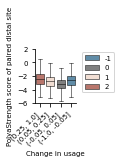


Corresponding statistics-
	Wilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:	 -7.596 3.06E-14
	Wilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:	-13.742 5.67E-43

Summary data-
                count      mean       std       min       25%       50%  \
sigbinR                                                                   
(0.25, 1.0]     955.0 -2.393535  1.171423 -5.617917 -3.223494 -2.473913   
(0.05, 0.25]   1157.0 -2.711619  1.083445 -6.251997 -3.434259 -2.767081   
(-0.05, 0.05]   612.0 -3.195738  1.024254 -6.089285 -3.833724 -3.244801   
(-1.0, -0.05]   252.0 -2.636133  1.073731 -5.771442 -3.310312 -2.672638   

                    75%       max  
sigbinR                            
(0.25, 1.0]   -1.729477  2.478335  
(0.05, 0.25]  -2.123134  2.198224  
(-0.05, 0.05] -2.611363  2.005850  
(-1.0, -0.05] -1.994027  1.565659  


In [38]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1))

sns.boxplot(data = sig_prox, 
            x = 'sigbinR', y = 'strength_paired', 
            hue = 'sigbinL', palette = dark_cmap, dodge = False,
            **boxplot_format, ax = ax)

ax.set_xlabel("Change in usage")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("PolyaStrength score of paired distal site")
ax.set_ylim(-6,2)
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'delta_usage.strength_paired.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print(f"\nCorresponding statistics-")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'strength_paired'],
                         sig_prox.loc[sig_prox['sigbinL'] == -1,'strength_paired'])
print(f"\tWilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'strength_paired'],
                         sig_prox.loc[sig_prox['sigbinL'] == 2, 'strength_paired'])
print(f"\tWilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

print("\nSummary data-")
print(sig_prox.groupby('sigbinR')['strength_paired'].describe())


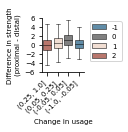


Corresponding statistics-
	Wilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:	  7.646 2.07E-14
	Wilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:	 13.270 3.45E-40

Summary data-
                count      mean       std       min       25%       50%  \
sigbinR                                                                   
(0.25, 1.0]     955.0 -0.094488  1.793649 -6.513414 -1.175698 -0.008521   
(0.05, 0.25]   1157.0  0.447394  1.750059 -6.523585 -0.617506  0.461363   
(-0.05, 0.05]   612.0  1.209039  1.706786 -4.917254  0.056545  1.175453   
(-1.0, -0.05]   252.0  0.257277  1.499381 -3.964406 -0.685282  0.167450   

                    75%       max  
sigbinR                            
(0.25, 1.0]    1.137240  5.225696  
(0.05, 0.25]   1.488598  6.526084  
(-0.05, 0.05]  2.254670  6.043136  
(-1.0, -0.05]  1.175524  4.835482  


In [39]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1))

sns.boxplot(data = sig_prox, 
            x = 'sigbinR', y = 'strength_difference', 
            hue = 'sigbinL', palette = dark_cmap, dodge = False,
            **boxplot_format, ax = ax)

ax.set_xlabel("Change in usage")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("Difference in strength\n(proximal - distal)")
ax.set_ylim(-6,6)
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'delta_usage.strength_difference.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print(f"\nCorresponding statistics-")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'strength_difference'],
                         sig_prox.loc[sig_prox['sigbinL'] == -1,'strength_difference'])
print(f"\tWilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'strength_difference'],
                         sig_prox.loc[sig_prox['sigbinL'] == 2, 'strength_difference'])
print(f"\tWilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

print("\nSummary data-")
print(sig_prox.groupby('sigbinR')['strength_difference'].describe())


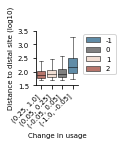


Corresponding statistics-
	Wilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:	 -9.783 1.33E-22
	Wilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:	  3.539 4.02E-04

Summary log data-
                count      mean       std      min       25%       50%  \
sigbinR                                                                  
(0.25, 1.0]     955.0  1.940099  0.230497  1.69897  1.778151  1.886491   
(0.05, 0.25]   1157.0  1.953207  0.232325  1.69897  1.785330  1.892095   
(-0.05, 0.05]   612.0  1.992802  0.271336  1.69897  1.799341  1.913814   
(-1.0, -0.05]   252.0  2.236732  0.368978  1.70757  1.936994  2.180410   

                    75%       max  
sigbinR                            
(0.25, 1.0]    2.021189  3.404149  
(0.05, 0.25]   2.056905  3.401917  
(-0.05, 0.05]  2.108055  3.475235  
(-1.0, -0.05]  2.501401  3.886773  

Summary raw data-
                count        mean         std   min   25%    50%     75%  \
sigbinR                             

In [40]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1))

sns.boxplot(data = sig_prox, 
            x = 'sigbinR', y = 'pair_distance_log10', 
            hue = 'sigbinL', palette = dark_cmap, dodge = False,
            **boxplot_format, ax = ax)

ax.set_xlabel("Change in usage")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("Distance to distal site (log10)")
ax.set_ylim(1.5,3.5)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'delta_usage.pair_distance.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print(f"\nCorresponding statistics-")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'pair_distance_log10'],
                         sig_prox.loc[sig_prox['sigbinL'] == -1,'pair_distance_log10'])
print(f"\tWilcoxon rank sum test for (-1.0,-0.05] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(sig_prox.loc[sig_prox['sigbinL'] == 0, 'pair_distance_log10'],
                         sig_prox.loc[sig_prox['sigbinL'] == 2, 'pair_distance_log10'])
print(f"\tWilcoxon rank sum test for (0.25,1.0] vs (-0.05,+0.05] sites:\t{stat:7.03f} {pval:8.02E}")

print("\nSummary log data-")
print(sig_prox.groupby('sigbinR')['pair_distance_log10'].describe())

print("\nSummary raw data-")
print(sig_prox.groupby('sigbinR')['pair_distance'].describe())
